# Q-learning en el ambiente del Frozen Lake

**Alicia Muñiz Jiménez**


La clave para resolver problemas de aprendizaje por refuerzo (RL) es encontrar la política óptima ($\pi^{*}$) de la función de valor para el problema específico. El Q-learning es un algoritmo del tipo modelo libre del RL basado en valor y es un policy off-learner, es decir, depende del ensayo y error para actualizar su experiencia y conocimiento del entorno, ya que tienen que aprender la dinámica del sistema a través de la experiencia y aprende el valor de la política óptima independientemente del tipo de acciones del agente, así como que las actualizaciones de la función de valor se basan en la ecuación de Bellman  (Jang, Kim, Harerimana y Kim, 2019).


Su Q proviene de quality (cualidad en inglés), ya que el Q-learning representa qué tan útil es una acción en ganar una recompensa a futuro (Shyalika, 2019). Es así que el Q-learning estima la función $Q(s,a)$ que es el valor esperado de hacer una acción 'a' en un estado 's' para estimar la política óptima y la ecuación de actualización de los valores $Q(s,a)$ es la siguiente:


$$
Q(s, a) \leftarrow Q(s, a) + \alpha [ r(s, a) + γmax Q' (s',a') - Q(s, a) ]
$$


Donde:

*   $r(s,a)$ = recompensa obtenida en ese estado dada una acción.
*   $γ$ = factor de descuento para el estado futuro (al que se transitará), su valor es fijo y puede tomar el rango de valores de [0,1].
*   $α$ = parámetro de aprendizaje, no es fijo ya que al inicio comienza en 1 y con cada iteración irá disminuyendo su valor hasta alcanzar el valor de 0 o un límite inferior definido de antemano (ej. 0.01).
*   $Q(s, a)$ = valor Q del estado actual dada la acción a.
*   $max Q'(s', a')$ = máxima futura recompensa esperada del estado nuevo al que se transitará.


Como se puede apreciar en la ecuación anterior, el Q-learning usa el método de diferencias temporales para la actualización o estimación de los valores Q, ya que sólo toma en cuenta el estado actual y el siguiente estado para estimar los valores Q (Matiisen, s. f.). Por otro lado, cuando el Q-learning es ejecutado se crea lo que se llama una tabla-Q, que es una matriz donde las filas normalmente representan cada estado posible y las columnas las acciones posibles en cada estado (Aggarwal, s.f. ). Por lo tanto, cada entrada de la matriz es un par estado-acción. La tabla siempre se inicializa con todos los valores en 0 y se actualiza cada entrada con la ecuación de actualización de los valores Q, de acuerdo con lo que el agente explora en cada iteración. La tabla al final sirve como referencia para que el agente pueda seleccionar la mejor acción basada en los valores Q.

Finalmente, es importante recalcar que en el Q-learning el agente trabaja con una política epsilon-greedy, mas esta política no tiene valores fijos, sino que al inicio el algoritmo tiene un  epsilon de 1 y con cada iteración este valor va disminuyendo hasta terminar en 0 o en un límite inferior como 0.01, si es que así se especifica de antemano (Matiisen, s.f.). Esto se debe a que como el algoritmo no tiene conocimiento de la dinámica del sistema al inicio, entonces necesita explorar mucho para conocer el entorno, pero conforme va conociendo más del entorno puede explotar cada vez más y no solo explorar.

Después de la breve introducción al Q-learning, ahora se procederá con un ejemplo práctico sobre dos agentes que interactúan en el entorno virtual "Frozen Lake" del gimnasio OpenAI, esto para entender mejor el Q-learning y las diferencias que se pueden observar al compararlo con un agente que tiene una política de elección de comportamiento de acciones aleatorias.



## Explicación del ambiente

La documentación de la paquetería *gymnasium* describe las siguientes características del ambiente *Frozen Lake* (Farama Foundation, 2023):

* **Estado de acciones (4):**

    - 0 = Izquierda
    - 1 = Abajo
    - 2 = Derecha
    - 3 = Arriba

* **Espacio observacional (16):** Se utilizará el ambiente de Frozen Lake con una cuadrícula de tamaño 4x4, por lo que el total de observaciones posibles (estados) son 16, como se puede ver en la imagen de abajo.


* **Recompensas:**

     - +1 si el agente alcanza la meta.
     - 0 si el agente cae en algún hoyo en el hielo.
     - 0 si el agente pasa por estados donde hay hielo congelado.



Un ejemplo de la exploración que hace el agente se puede visualizar de la siguiente forma:

![image](Images/FrozenLake.gif)

# Código

**Instalación e importación de librerías**

In [1]:
#Instalación de paqueterías necesarias para usar el ambiente virtual de gymnasium sin problemas

#!pip install gymnasium[toy-text]
#!pip install pyglet==1.5.27

In [2]:
#importación de librerías que se usarán en el código

import numpy as np
import pandas as pd
import gymnasium as gym
import math
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(12345)

# Agente con acciones aleatorias

**Creación del ambiente virtual de Frozen Lake**

Para implementar un agente de aprendizaje supervisado; determinamos, en primer lugar, un ambiente. Este se determina por una cuadrícula de $n\times n$. En la paquetería de Gymnasium, se usa la función <tt>make</tt> y le indicamos que queremos un ambiente de Frozen Lake. Este ambiente simula un entorno en que una gente se mueve con las acciones antes indicadas para llegar a una meta; en el ambiente hay obstáculos, que son hoyos donde el agente puede caer. Como resultado, se necesitan indicar los siguientes elementos:


1. Se especifica la estructura del entorno con una cuadrícula de $n\times n$ (en este caso $4\times 4$) con el comando **desc = ["SFFF", "FHFF", "FFFH", "FFFG"]** (se pueden variar el orden de sus elementos), donde:

    * S = posición inicial del agente (start)
    * F = hielo (frozen)
    * H = hoyo
    * G = meta (goal)

2. El comando **is_slippery=True** implica que el suelo está resbaloso y hace que el agente se mueva con una probabilidad de 1/3 a la casilla deseada y con un 1/3 de probabilidad a las casillas perpendiculares a la acción deseada. Si es **False** el agente se mueve a la casilla deseada siempre.

3. El comando **render_mode="human"** sirve para visualizar al entorno gráficamente, si es igual a **"ansi"** entonces los valores de las acciones se guardan en un string que contiene una representación de texto de estilo terminal para cada paso temporal, aunque sólo se visualiza este string si es solicitado.

In [3]:
#creación del ambiente virtual con la paquetería gymnasium
env=gym.make("FrozenLake-v1",
             desc=["SFFF", "FHFF", "FFFH", "FFFG"],
             is_slippery=False,
             render_mode="human")

#Índices de las acciones
action_names = {0:'Izquierda', 1: 'Abajo', 2: 'Derecha', 3: 'Arriba'}

#Número de acciones
action_space_size = env.action_space.n
#Número de estados(cuadros)
state_space_size = env.observation_space.n

print('Ambiente:\n{}\n Núm. estados: {} \n Núm. acciones: {}'.format(env.get_wrapper_attr('desc'), state_space_size, action_space_size))

Ambiente:
[[b'S' b'F' b'F' b'F']
 [b'F' b'H' b'F' b'F']
 [b'F' b'F' b'F' b'H']
 [b'F' b'F' b'F' b'G']]
 Núm. estados: 16 
 Núm. acciones: 4


A modo de prueba se programaron 10 episodios con un agente que elige sólo acciones aleatorias para ver cómo se comportaría y comparar al final este agente con el agente que aprende con Q-learning.


In [4]:

episodios = 10

for episodio in range(1, episodios+1):

    #Estado inicial
    estado = env.reset()
    done = False                    #done = False implica que el agente no ha llegado a la meta
    score = 0

    actions = []
    while not done:

        #visualizar el ambiente
        #env.render()                #quitar comentario para visualizar

        #Muestrea una acción aleatoria
        action = env.action_space.sample()
        actions.append(action_names[action])

        #Actualización de las variables en el ambiente por la acción tomada
        _, reward, done, _, _ = env.step(action)
        score += reward

    print('Ensayo:{}\n\tAcciones:{}; Recompensa: {}'.format(episodio, actions, score))

env.close()


Ensayo:1
	Acciones:['Izquierda', 'Izquierda', 'Abajo', 'Derecha']; Recompensa: 0.0
Ensayo:2
	Acciones:['Derecha', 'Arriba', 'Izquierda', 'Derecha', 'Izquierda', 'Arriba', 'Arriba', 'Derecha', 'Abajo']; Recompensa: 0.0
Ensayo:3
	Acciones:['Arriba', 'Derecha', 'Izquierda', 'Arriba', 'Derecha', 'Derecha', 'Abajo', 'Abajo', 'Abajo', 'Izquierda', 'Abajo', 'Abajo', 'Abajo', 'Abajo', 'Abajo', 'Derecha', 'Arriba', 'Izquierda', 'Arriba']; Recompensa: 0.0
Ensayo:4
	Acciones:['Derecha', 'Arriba', 'Arriba', 'Arriba', 'Arriba', 'Arriba', 'Abajo']; Recompensa: 0.0
Ensayo:5
	Acciones:['Arriba', 'Abajo', 'Izquierda', 'Izquierda', 'Abajo', 'Derecha', 'Arriba']; Recompensa: 0.0
Ensayo:6
	Acciones:['Derecha', 'Arriba', 'Abajo']; Recompensa: 0.0
Ensayo:7
	Acciones:['Arriba', 'Arriba', 'Izquierda', 'Derecha', 'Arriba', 'Arriba', 'Arriba', 'Izquierda', 'Derecha', 'Izquierda', 'Izquierda', 'Arriba', 'Arriba', 'Arriba', 'Abajo', 'Arriba', 'Derecha', 'Abajo']; Recompensa: 0.0
Ensayo:8
	Acciones:['Derecha', 'De

# Agente con el algoritmo de Q-learning

### Creación del entorno virtual para el nuevo agente

Se volverá a crear el ambiente virtual porque a diferencia del agente de acciones aleatorias, en este ambiente se usará render_mode="ansi", ya que como el agente necesitará muchos episodios para aprender, es mejor no visualizar al agente en el ambiente, sino sería más tardado el aprendizaje por el costo computacional.

In [5]:
# creación del ambiente del agente que aprenderá con Q-learning
env=gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFFH", "FFFG"], is_slippery=False, render_mode="ansi")

Se confirman cuántas acciones posibles hay:

In [6]:
env.action_space.n

4

Se confirman cuántos estados hay en el ambiente:

In [7]:
env.observation_space.n

16

Se crea una tabla Q (Q_table), que es una matriz donde las filas representan cada estado posible y las columnas las acciones posibles en cada estado. Esta se inicializa con todos sus valores en cero y conforme el agente aprenda actualizará los valores de cada entrada.

In [8]:
Q_table = np.zeros((env.observation_space.n,env.action_space.n ))

#para visualizar la Q-table como un data frame
df=pd.DataFrame(data=Q_table, columns=['Izquierda', 'Abajo', 'Derecha', 'Arriba'])
df.index = [i+1 for i in range(len(df))]
df.columns.name = 'Estado'
df

Estado,Izquierda,Abajo,Derecha,Arriba
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0


## Funciones

**Tasa de aprendizaje (learning_rate)**

En Q-learning el agente en los primeros episodios aprende mucho porque el agente no tiene un modelo del entorno, pero conforme va conociendo el entorno su tasa de aprendizaje irá disminuyendo, es decir, la tasa de aprendizaje es dinámica (no es fija).

Si se analiza el siguiente código se puede ver al inicio la tasa de aprendizaje comienza en 1 y con cada iteración irá disminuyendo su valor hasta alcanzar el límite de 0.01. Los argumentos que toma la función son:

* **n** = Episodio en el que está el agente (se aprecia en partes del código más adelante cuando se usa la función).
* **min_rate** = Límite inferior que puede alcanzar la tasa de aprendizaje. Este límite se pone porque se quiere que el agente siempre siga aprendiendo en cierta medida, aunque ya tenga un buen modelo del entorno.

In [9]:
def learning_rate(n : int , min_rate=0.01 ) -> float  :
    """Tasa de decaimiento del aprendizaje por cada episodio"""

    return max(min_rate, min(1.0, 1.0 - math.log10((n + 1) / 25)))

**Tasa de exploración (exploration_rate)**

Hay que recordar que en Q-learning al principio se explora mucho porque el agente no tiene un modelo del entorno y debe explorar para aprender, pero con el paso de los episodios comenzará a explotar más.

En el siguiente código se puede ver que la tasa de exploración se inicializa en 1 y va disminuyendo en cada episodio hasta alcanzar un límite de 0.1. Los argumentos que toma la función son:
* **n** = Episodio en el que está el agente (se aprecia en partes del código más adelante cuando se usa la función).
* **min_rate** = Límite inferior que puede alcanzar la tasa de exploración. Este límite se pone porque lo que se quiere es que el agente siga explorando de vez en cuando, aunque ya tenga un buen modelo del entorno.

In [10]:
def exploration_rate(n : int, min_rate= 0.1 ) -> float :
    """Tasa de decaimiento de exploración en cada episodio"""
    #
    return max(min_rate, min(1, 1.0 - math.log10((n  + 1) / 25)))

**Política epsilon-greedy**

La política epsilon-greedy elige la opción de mayor recompensa la mayoría de las
veces y con probabilidad ϵ elige aleatoriamente el resto de las veces (Francois-Lavent et al., 2018).

El código a continuación muestra que si un número aleatorio es menor que la tasa de exploración, entonces se decide explorar, sino, se explota al elegir el argumento máximo de las acciones del Q-table (dado un estado específico).

In [11]:
def policy_e_greedy(current_state : tuple):
    """Regla de decisión basada en una política epsilon-greedy, dado en el estado que se está"""

    # explorar (acción aleatoria)
    if np.random.random() < exploration_rate(e):
        action = env.action_space.sample()

    # explotar
    else:
        action = np.argmax(Q_table[current_state])

    return action

**Actualización del valor Q**

En Q-learning se emplea el método de diferencias temporales para actualizar los valores Q (recordemos que un valor Q es la entrada de un par estado-acción de la tabla Q), porque para actualizar lo aprendido sólo se toma en cuenta el estado actual y el siguiente.

El siguiente código corresponde la ecuación mencionada al inicio:

$$
Q(s, a) \leftarrow Q(s, a) + \alpha [ r(s, a) + γmax Q' (s',a') - Q(s, a) ]
$$

In [12]:

def new_Q_value( reward : float , action, current_state, new_state : tuple , discount_factor=1 ) -> float:
    """
    Actualización del Q-value de un par estado-acción con el método de diferencias temporales:

       reward = recompensa obtenida en el estado actual.
       action = acción realizada
       current_state = estado actual
       new_state = estado siguiente
       discount_factor = el peso que se le da al estado siguiente (entre más cercano a 1, más importa).

    """
    act_val = Q_table[current_state, action]                             #se obtiene el valor del estado actual
    fut_opt_val = np.max(Q_table[new_state])                             #se obtiene el valor del estado siguiente
    learned_value = reward + discount_factor * fut_opt_val-act_val       # r(s, a) + γmax Q' (s',a') - Q(s, a)
    new_val = (1-lr)*act_val + lr*(learned_value)

    return new_val

**Etapa de entrenamiento-aprendizaje**

In [13]:
#Etapa de entrenamiento/aprendizaje

num_episodio = []         #lista donde se irán guardando el número de episodio
puntajes_ep = []          #lista donde se irán guardando los puntajes por episodio

n_episodes = 500         #se entrenará al agente con 1000 episodios

for e in range(1, n_episodes+1):

    #Estado inicial
    current_state = env.reset()[0]
    done = False
    num_episodio.append(e)
    score = 0

    actions = []
    while done==False:

        #Se selecciona la acción con la política epsilon greedy
        action = policy_e_greedy(current_state)
        actions.append(action_names[action])

        #Actualización de las variables en el ambiente
        #a partir de la acción tomada
        obs, reward, done, _, _ = env.step(action)

        new_state = obs
        score += reward
        lr = learning_rate(e)                         #se actualiza la tasa de aprendizaje

        #Se actualiza el valor Q
        Q_table[current_state, action] = new_Q_value(reward, action, current_state, new_state)

        #Se transita al nuevo estado
        current_state = new_state

    puntajes_ep.append(score)

    #impresión de resultados cada 100 episodios
    if e % 100 == 0:
        puntaje = puntajes_ep[e-1]

        print('Episode {}\n\tPuntaje:{}; Acciones:{}'.format(e, score, actions))



Episode 100
	Puntaje:1.0; Acciones:['Arriba', 'Derecha', 'Derecha', 'Izquierda', 'Derecha', 'Izquierda', 'Izquierda', 'Abajo', 'Abajo', 'Abajo', 'Arriba', 'Abajo', 'Derecha', 'Derecha', 'Derecha']
Episode 200
	Puntaje:1.0; Acciones:['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']
Episode 300
	Puntaje:1.0; Acciones:['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']
Episode 400
	Puntaje:1.0; Acciones:['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']
Episode 500
	Puntaje:1.0; Acciones:['Izquierda', 'Abajo', 'Arriba', 'Abajo', 'Arriba', 'Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']


**Graficación de los puntajes por episodio**

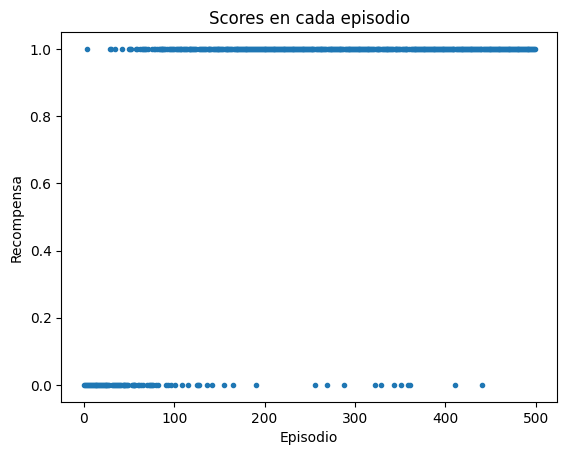

In [14]:
plt.plot(puntajes_ep,'.')
plt.title('Scores en cada episodio')
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.show()

**Visualización del Q-table después del aprendizaje**

Recordemos que las filas representan los 16 diferentes estados y las columnas las 4 diferentes acciones. El hecho de la tabla tenga valores diferentes de 0 significa que el agente aprendió algo. En cada fila la entrada con un valor más cercano a uno representa la acción más óptima, porque se elige el argumento máximo del estado cuando se explota. Las filas con sólo ceros es porque probablemente el agente nunca pasó por ese estado o porque es la meta.

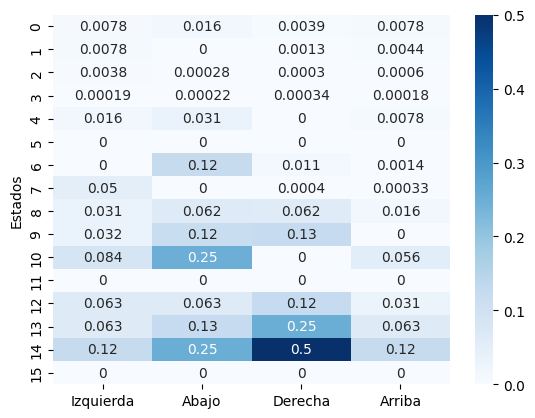

In [15]:
from seaborn import heatmap

datos = pd.DataFrame(data=Q_table, columns=['Izquierda', 'Abajo', 'Derecha', 'Arriba'])
heatmap(datos, cmap='Blues', annot=True, square=False)
plt.ylabel('Estados')
plt.show()

## Prueba de aprendizaje

En esta parte del código el agente ya no aprenderá, sino que se utilizará el Q-table para que el agente seleccione las acciones.

**Correr esta parte del código sólo si se ha corrido toa las partes del código del apartado "Agente con Q-learning".**

In [16]:
#Se crea el ambiente virtual
env=gym.make("FrozenLake-v1",desc=["SFFF", "FHFF", "FFFH", "FFFG"], is_slippery=False, render_mode="human")

In [17]:
#Se evalúa el agente en 5 episodios

n_episodes_t = 5

for e in range(1, n_episodes_t+1):

    current_state = env.reset()[0]
    done = False
    score = 0

    actions = []
    while done==False:

        # política de acción
        action = np.argmax(Q_table[current_state]) #la accion del agente es siempre explotar
        actions.append(action_names[action])

        #se obtienen los resultados del ambiente por la acción elegida
        obs, reward, done, _,_= env.step(action)
        score += reward

        #se transita al nuevo estado
        current_state = obs

    print('Episodio: {}\n\tAcciones: {}; Puntaje: {}'.format(e, actions, score))

env.close()

Episodio: 1
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']; Puntaje: 1.0
Episodio: 2
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']; Puntaje: 1.0
Episodio: 3
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']; Puntaje: 1.0
Episodio: 4
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']; Puntaje: 1.0
Episodio: 5
	Acciones: ['Abajo', 'Abajo', 'Abajo', 'Derecha', 'Derecha', 'Derecha']; Puntaje: 1.0


**Ejercicio:**

    1) Modificar el código en la etapa de entrenamiento para que corra sólo 20 episodio (n_episodes = 20) y correr todo el código que sigue. ¿Qué cambios observas en la tabla Q? ¿En la etapa de prueba o testing el agente sí llega a la meta o qué pasa?

    2) ¿Cuáles son las diferencias en la conducta del agente de acciones aleatorias y el agente con el algoritmo de Q-learning?


**Referencias:**

* Aggarwal, R. (s. f.). Q-learning - Reinforcement Learning. Recuperado el 15 de diciembre de 2022. https://miet.ac.in/assets/uploads/cs/Q%20Learning.pdf

* Brooker, R. (2020). OpenAI Gym: CartPole-v1 - Q-Learning [Youtube]. https://www.youtube.com/watch?v=JNKvJEzuNsc&t=227s

* Jang, B. Kim, M. Harerimana, G. y Kim, J.W. (2019). "Q-Learning Algorithms: A Comprehensive Classification and Applications,". IEEE Access, vol. 7,133653-133667, doi: 10.1109/ACCESS.2019.2941229

* Matiisen, T. (s. f.). Q-learning [Presentación]. Recuperado el 15 de diciembre de 2022. https://courses.cs.ut.ee/MTAT.03.292/2014_spring/uploads/Main/Q-learning.pdf

* Francois-Lavet, V. Henderson, P. Islam, R. Bellemare, M. G. y Pineau, J. (2018).
Foundations and Trends in Machine Learning, 11 (3-4).
https://doi.org/10.1561/2200000071

* Farama Foundation. (2023). Frozen Lake. Gymnasium Documentation. Recuperado el 28 de marzo de 2023. https://gymnasium.farama.org/environments/toy_text/frozen_lake/

* Shyalika, C. (2019). A Beginners Guide to Q-Learning. En Towards Data Science. Recuperado el 8 de diciembre de 2022. https://towardsdatascience.com/a-beginners-guide-to-q-learning-c3e2a30a653c
